In [1]:
import fcsparser as fcs
import os
import pandas as pd
import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.stats as stats
from scipy.optimize import curve_fit

sns.set(style="white")
sns.set_context("notebook")
warnings.filterwarnings("once")

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

tick_setup = {'labelsize' : SMALL_SIZE,
              'major.pad': 0}

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', **tick_setup)    # fontsize of the tick labels
plt.rc('ytick', **tick_setup)
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def gate_density (df, threshold, y_var='FSC-A', x_var='SSC-A'):
    
    ymin = df[y_var].min()
    ymax = df[y_var].max()
    xmin = df[x_var].min()
    xmax = df[x_var].max()
                                                                                                                                
    #Perform a kernel density estimate on the data:
    df_mini = df.sample(1000)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([df_mini[x_var], df_mini[y_var]])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    cut = Z.max()*threshold
    
    # threhold dataframe
    df['gate'] = kernel([df[x_var], df[y_var]])
    df2 = df[df.gate > cut]
    return df2

In [9]:
outputdir = "/Volumes/Coatamer/Users/weinberz/Google Drive/HES Lab/SARSNotch/SARSNotch Manuscript/jupyter_out/"

In [2]:
folder="/Volumes/Coatamer/Users/weinberz/Box/BadIdea/Flow/20201026 - 46,2f,47 Triplicate No 2/"

In [3]:
ffolderlist = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

df=pd.DataFrame()
aa=1
    #load all fcs files
for fdn in ffolderlist:
    ffilelist = os.listdir(folder+fdn)
    for fn in ffilelist:
        filename, file_ext = os.path.splitext(fn)
        if file_ext ==".fcs":
            path = folder + fdn + "//" + fn
            meta, df1 = fcs.parse(path, meta_data_only=False, reformat_meta=True)
            df1["WellName"]=fn.split("_")[3].split(".")[0]
            df1["WellNumber"]= aa
            df=df.append(df1)
            aa=aa+1

# metadata file
meta = folder+ "metadata.csv"
df1=pd.read_csv(meta, names=["WellName", "CellLine","Treatment","Dose", 'Replicate'])

df=df1.merge(df, on=["WellName"])

In [12]:
#remove small events
df2 =df[df["FSC-A"]>5E4]
df2 =df2[df2["SSC-A"]>2.5E4]

#remove NAs
df2= df2.loc[(df2.select_dtypes(include=['number']) > 0).all(axis='columns'), :]
df2=df2.dropna()

#gate cells
df2 = df2.groupby(['WellName']).apply(gate_density, 0.05, x_var='FSC-A', y_var='SSC-A')

#log data
for col in df2.columns:
    if df2[col].dtype=="float32":
        df2["log"+ col]=df2[col].apply(math.log10)

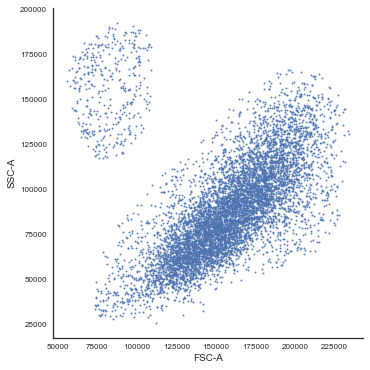

In [17]:
#Visualize populations for Jurkats (well B01) and K562s (well A02)
sns.lmplot(y="SSC-A", x="FSC-A", data=df2[df2["WellName"].isin(['A01'])], fit_reg=False, scatter_kws={'s': 1})
plt.show()

In [18]:
# generate a dose response curve fitted to a Hill function:
def plot_dose_response(df, metric, ax = None, label='', c='b'):
    df['Dose'] = pd.to_numeric(df['Dose'])
    qt95 = np.percentile(df.loc[df['Dose'] == 0, metric], 90)
    df = df[df['Dose'] != 0]
    dr = df.groupby(['Dose', 'Replicate'])[metric].apply(lambda x: 100*np.sum(x>qt95)/len(x)).reset_index()    
    
    def func(x, a, b, c, alpha): # Hill sigmoidal equation from zunzun.com
        return  a * (alpha + ((1-alpha) * (np.power(x, b) / (np.power(c, b) + np.power(x, b)))))
    
    fittedParameters, pcov = curve_fit(func, dr['Dose'], dr[metric], maxfev=20000)
    x_model = np.logspace(-3, 5, num=100)
    y_model = func(x_model, *fittedParameters) 
    
    if not ax:
        fig, ax = plt.subplots(1,1)
    
    output = dr.groupby('Dose')[metric].agg([np.mean, np.std]).reset_index()
    ax.errorbar(output['Dose'], output['mean'], yerr=output['std'], fmt='-',marker='.', markersize=10, c=c, label=label)
#     ax.plot(x_model, y_model, label=label, c=c)
    ax.set_xscale('log')
    ax.set_xlim([0.05, 500])
    sns.despine()
    plt.show

/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


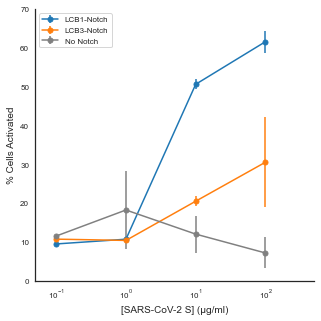

In [19]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
pal = list(plt.get_cmap('tab10').colors[:2]) + ['gray']
notches = ['LCB1-Notch', 'LCB3-Notch', 'No Notch']
for notch, c in zip(notches, pal):
    plot_dose_response(df2[(df2['CellLine'] == notch) &
                           (df2['Treatment'].isin(['PBS', 'Spike']))], 
                       'logBV 421-A', ax=ax, label=notch, c=c)

plt.legend(loc='upper left')
plt.xlabel('[SARS-CoV-2 S] (µg/ml)')
plt.ylabel('% Cells Activated')
plt.ylim([0,70])
plt.savefig('20201026_triplicate_data.eps')
plt.show()

In [24]:
qt = np.percentile(df2[(df2['CellLine'] == 'No Notch') &
                       (df2['Dose'] == '0')]['logBV 421-A'],90)
summary = (df2[(df2['Treatment'] == 'Spike')]
              .groupby(['CellLine', 'Dose', 'Replicate'])['logBV 421-A']
              .apply(lambda x: 100*np.sum(x>qt)/len(x))
              .reset_index())
summary['Dose'] = pd.to_numeric(summary['Dose'])
#we need to adjust dose, since the metadata is wrong for this and we were actually an order of magnitude less potent
summary['Dose'] = summary['Dose']/10

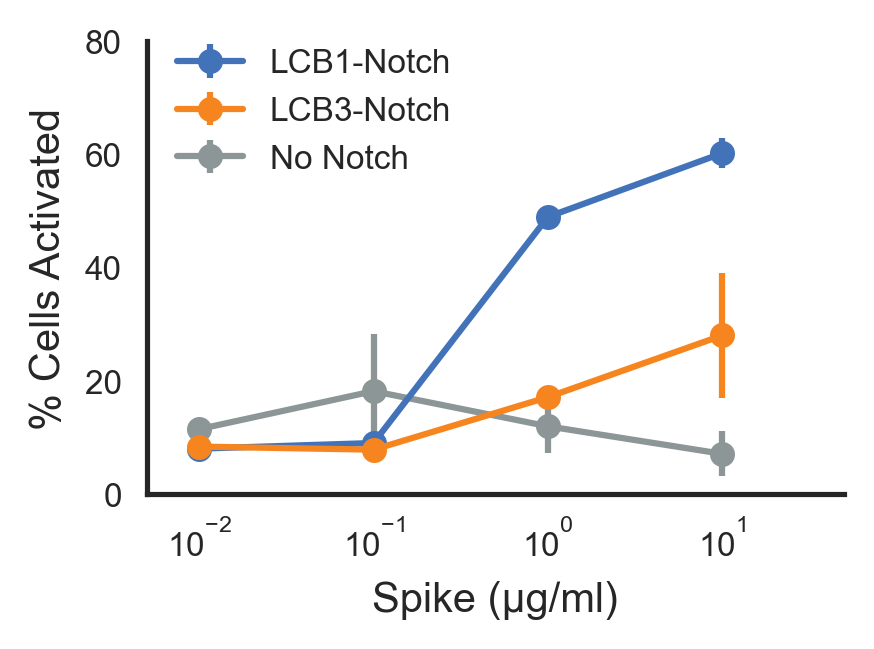

In [27]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for notch, color in zip(['No Notch', 'LCB1-Notch', 'LCB3-Notch'],['#8C9696','#4272B8','#F6851F']):
    notch_summary = summary[(summary['CellLine']==notch) & (summary['Dose'] != 0)]
    output = notch_summary.groupby('Dose')['logBV 421-A'].agg([np.mean, np.std]).reset_index()
    ax.errorbar(output['Dose'], output['mean'], yerr=output['std'], fmt='-',marker='.', markersize=10, c=color, label=notch)

ax.set_xscale('log')
ax.set_xlim([0.005, 50])
ax.set_xlabel('Spike (µg/ml)')
ax.set_ylabel('% Cells Activated')
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [1, 2, 0]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylim([0,80])
sns.despine()
plt.savefig(outputdir + 'lcb1_vs_lcb3.svg')

In [12]:
# generate a dose response curve fitted to a Hill function:
def plot_dose_response(df, metric, ax = None, label='', c='b'):
    df['Dose'] = pd.to_numeric(df['Dose'])
    qt95 = np.percentile(df.loc[df['Dose'] == 0, metric], 90)
    df = df[df['Dose'] != 0]
    dr = df.groupby(['Dose', 'Replicate'])[metric].apply(lambda x: 100*np.sum(x>qt95)/len(x)).reset_index()    
    
    def func(x, a, b, c, alpha): # Hill sigmoidal equation from zunzun.com
        return  a * (alpha + ((1-alpha) * (np.power(x, b) / (np.power(c, b) + np.power(x, b)))))
    
    fittedParameters, pcov = curve_fit(func, dr['Dose'], dr[metric], maxfev=20000)
    x_model = np.logspace(-3, 5, num=100)
    y_model = func(x_model, *fittedParameters) 
    
    if not ax:
        fig, ax = plt.subplots(1,1)
    
    output = dr.groupby('Dose')[metric].agg([np.mean, np.std]).reset_index()
    ax.errorbar(output['Dose'], output['mean'], yerr=output['std'], fmt='-',marker='.', markersize=10, c=c, label=label)
#     ax.plot(x_model, y_model, label=label, c=c)
    ax.set_xscale('log')
    ax.set_xlim([0.05, 500])
    sns.despine()
    plt.show

/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


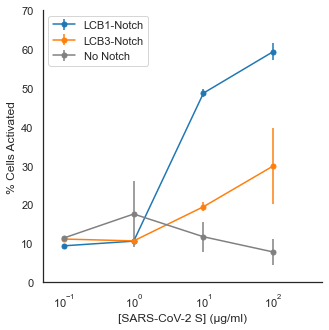

In [17]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
pal = list(plt.get_cmap('tab10').colors[:2]) + ['gray']
notches = ['LCB1-Notch', 'LCB3-Notch', 'No Notch']
for notch, c in zip(notches, pal):
    plot_dose_response(df2[(df2['CellLine'] == notch) &
                           (df2['Treatment'].isin(['PBS', 'Spike']))], 
                       'logBV 421-A', ax=ax, label=notch, c=c)

plt.legend(loc='upper left')
plt.xlabel('[SARS-CoV-2 S] (µg/ml)')
plt.ylabel('% Cells Activated')
plt.ylim([0,70])
plt.savefig('20201026_triplicate_data.eps')
plt.show()

/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/Caskroom/minic

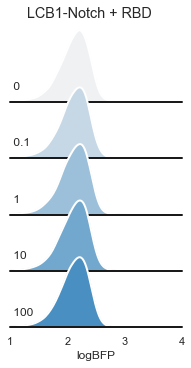

In [7]:
with sns.light_palette(plt.get_cmap('tab10').colors[0], 6):
    g = sns.FacetGrid(data=df2[(df2['CellLine'] == 'LCB1-Notch') &
                               (df2['Treatment'].isin(['PBS', 'RBD']))],
                      row='Dose', hue='Dose', sharey=True, aspect=3, height=1, 
                      row_order = ['0', '0.1', '1', '10','100'],
                      hue_order = ['0', '0.1', '1', '10','100'], xlim=[1, 4])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=1, bw=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="w", lw=2, bw=.2, cut=0)
    g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    for ax in g.axes.flat:
        dose = ax.get_title().split("=")[1]
        ax.text(0,0.2, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
        ax.set(facecolor=(0, 0, 0, 0))

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.xlabel("logBFP")
    plt.suptitle('LCB1-Notch + RBD')

/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/Caskroom/minic

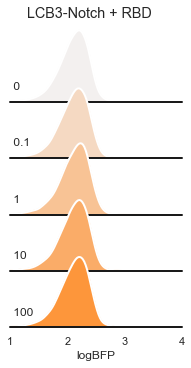

In [8]:
with sns.light_palette(plt.get_cmap('tab10').colors[1], 6):
    g = sns.FacetGrid(data=df2[(df2['CellLine'] == 'LCB3-Notch') &
                               (df2['Treatment'].isin(['PBS', 'RBD']))],
                      row='Dose', hue='Dose', sharey=True, aspect=3, height=1, 
                      row_order = ['0', '0.1', '1', '10','100'],
                      hue_order = ['0', '0.1', '1', '10','100'], xlim=[1, 4])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=1, bw=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="w", lw=2, bw=.2, cut=0)
    g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    for ax in g.axes.flat:
        dose = ax.get_title().split("=")[1]
        ax.text(0,0.2, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
        ax.set(facecolor=(0, 0, 0, 0))

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.xlabel("logBFP")
    plt.suptitle('LCB3-Notch + RBD')

/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/Caskroom/miniconda/base/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


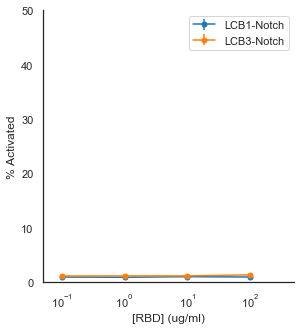

In [17]:
fig, ax = plt.subplots(1,1, figsize=(4.5,5))
pal = plt.get_cmap('tab10').colors[:2]
notches = ['LCB1-Notch', 'LCB3-Notch']
for notch, c in zip(notches, pal):
    plot_dose_response(df2[(df2['CellLine'] == notch) &
                           (df2['Treatment'].isin(['PBS', 'RBD']))], 
                       'logBV 421-A', ax=ax, label=notch, c=c)

plt.legend()
plt.xlabel('[RBD] (ug/ml)')
plt.ylabel('% Activated')
plt.ylim([0, 50])
plt.show()